In [1]:
""" Filter India data

aws emr add-steps --cluster-id <Your EMR cluster id> --steps Type=spark,Name=TestJob,Args=[--deploy-mode,cluster,--master,yarn,--conf,spark.yarn.submit.waitAppCompletion=true,s3a://your-source-bucket/code/pythonjob.py,s3a://your-source-bucket/data/data.csv,s3a://your-destination-bucket/test-output/],ActionOnFailure=CONTINUE
"""

from collections import namedtuple
import logging
import sys

import matplotlib.pyplot as plt

from geopy.distance import great_circle
import pandas as pd
import geopandas as gpd
import numpy as np

from datetime import timedelta, date, datetime
from statistics import *


from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import (
    StructType,
    LongType,
    StructField,
    IntegerType,
    StringType,
    DoubleType,
    TimestampType,
    ArrayType,
    BinaryType
)
import pyspark.sql.functions as F
from math import *
import time
import json
import boto3

from sedona.register import SedonaRegistrator  
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from pyspark.sql.functions import udf
from sedona.utils.adapter import Adapter
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.core.SpatialRDD import PointRDD, SpatialRDD, CircleRDD
from sedona.sql.types import GeometryType
from sedona.core.enums import GridType, IndexType
from sedona.core.spatialOperator import JoinQueryRaw
from sedona.core.spatialOperator import JoinQuery
from sedona.core.enums import IndexType
from sedona.core.formatMapper.disc_utils import load_spatial_rdd_from_disc, GeoType
from sedona.core.formatMapper import WktReader, GeoJsonReader
# from sedona.spark import *
#sedona = SedonaContext.create(config)

import os
from shapely.wkt import loads as wkt_loads
from shapely.geometry import Point, Polygon, shape
from shapely.ops import transform
import shapely

import s3fs

s3 = s3fs.S3FileSystem(anon=False)

spark = (SparkSession.builder.appName("sedona")
                 .config("spark.serializer", KryoSerializer.getName)          
        .config("spark.kryo.registrator",     
                  SedonaKryoRegistrator.getName)    
         .config("spark.driver.maxResultSize", "3g")
    .getOrCreate() 
        )

# Register Sedona UDTs and UDFs
SedonaRegistrator.registerAll(spark)
spark.sparkContext.addPyFile("s3://ipsos-dvd/scripts/utils.py")

bsdir = "s3://ipsos-dvd/fdd/"
data_dir = bsdir + "data/"
fn = data_dir +  "pings_IN_2021-09-01_2021-09-30/"

#-------
# parameters
crs = "epsg:3857"



def spatialIntersection(pings, poly, build_on_spatial_partitioned_rdd = True, using_index = True, origin_crs="epsg:4326", crs="epsg:4326", transform=True): 
    
    poly_rdd = Adapter.toSpatialRdd(poly, "geometry")

    pings.createOrReplaceTempView("pings")

    # Read Hive table
    if transform:
        pings = spark.sql(
              f"""SELECT ST_Transform(ST_FlipCoordinates(ST_Point(pings.longitude, 
              pings.latitude)), "{origin_crs}", "{crs}") AS point, 
              *
              FROM pings;
              """
        )
    else:
        pings = spark.sql(
              f"""SELECT ST_FlipCoordinates(ST_Transform(ST_FlipCoordinates(ST_Point(pings.longitude, 
              pings.latitude)), "{origin_crs}", "{crs}")) AS point, 
              *
              FROM pings;
              """
        )
    num_partitions = 1000
    pings = pings.repartition(num_partitions)
    pings = pings.cache()
    
    grid_type = GridType.QUADTREE # this shit works so much better for skewed data

    points_rdd = Adapter.toSpatialRdd(pings, "point")
    points_rdd.analyze()
    points_rdd.spatialPartitioning(grid_type)
    
    poly_rdd.analyze()
    poly_rdd.spatialPartitioning(points_rdd.getPartitioner())
    
     ## Set to TRUE only if run join query
    points_rdd.buildIndex(IndexType.QUADTREE, build_on_spatial_partitioned_rdd)
    
    result = JoinQueryRaw.SpatialJoinQueryFlat(points_rdd, poly_rdd, using_index, True)

    return Adapter.toDf(result, poly_rdd.fieldNames, points_rdd.fieldNames, spark)




VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1705527263949_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Get SafeGraph data

In [ ]:
places = (sqlContext.read.format('com.databricks.spark.csv')
         .options(header='true', inferschema='true')
         .option('escape','"') # this is necessary because the fields contain "," as well but dont have quotes around them
         .load("s3://external-safegraph-places-global-geometry/places/"))

In [3]:
places = places.filter(F.col("ISO_COUNTRY_CODE") == "IN")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
places.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

301085

In [5]:
places.repartition(1).write.mode("overwrite").option("delimiter", "\t").option("header", True).csv(data_dir + "safegraph_india")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Filter pings

In [2]:
india = spark.read.parquet(fn)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# filter on bounding box
minx, maxx = 68.716667, 80.983333 # Longitude
miny, maxy = 22.166667, 30.916667 # Latitude

# filter on rajastan
india = india.filter(F.col('longitude').between(minx, maxx) & F.col('latitude').between(miny, maxy))

# filter on internet blackout dates
india = india.withColumn("date", F.from_utc_timestamp(F.col("utc_timestamp").cast(TimestampType()), tz = "IST"))
# india = india.filter(F.to_date(F.col("date")).isin(["2021-09-05", "2021-09-12", "2021-09-19", "2021-09-26"]))
india = india.filter(F.to_date(F.col("date")).isin(["2021-09-06", "2021-09-13", "2021-09-20", "2021-09-27"]))


india.write.mode("overwrite").parquet("s3://ipsos-dvd/fdd/data/rajasatan_monday_sep_2021")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Intersect with shops and grid for subsampling

In [2]:
### First intersect shops

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# read data
pings = spark.read.parquet("s3://ipsos-dvd/fdd/data/rajasatan_sundays_sep_2021") # .sample(0.05)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
# load safegraph data
test = spark.read.option("delimiter", "\t").csv(data_dir + 'safegraph_india', header=True).toPandas()

temp = test[test.POLYGON_WKT.notna()]
def _wkt_loads(x):
    try:
        return wkt_loads(x)
    except:
        return None
temp['POLYGON_WKT'] = temp['POLYGON_WKT'].apply(_wkt_loads)
temp = temp[temp.POLYGON_WKT != None]
poly_raw = gpd.GeoDataFrame(temp, geometry=temp['POLYGON_WKT'], crs="epsg:4326")



#temp.drop(columns="POLYGON_WKT").to_file(os.path.join(data_out, 'safegraph_india.geojson'), driver='GeoJSON')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<string>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [49]:
temp = test[test.POLYGON_WKT.isna()]
poly_raw_2 = gpd.GeoDataFrame(temp, geometry=gpd.points_from_xy(temp.LONGITUDE, temp.LATITUDE), crs="epsg:4326")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
crs = "epsg:3857"
poly_raw_2 = poly_raw_2.to_crs(crs)
poly_raw_2['geometry'] = poly_raw_2['geometry'].buffer(150)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
crs = "epsg:3857"
poly_raw = poly_raw.to_crs(crs)
poly_raw['geometry'] = poly_raw['geometry'].buffer(100)
poly_raw = gpd.GeoDataFrame( pd.concat([poly_raw, poly_raw_2], ignore_index=True) )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
minx, maxx = 7649504.379451, 9015023.392302 # EPSG:3857 Longitude
miny, maxy = 2531547.394169, 3621931.489373 # EPSG:3857 Latitude
poly_raw = poly_raw.cx[minx:maxx, miny:maxy]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
poly_raw = poly_raw[['PLACEKEY', 'geometry']]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
poly_raw = poly_raw.rename(columns={"PLACEKEY": "id"})
poly_raw['origin'] = "sg"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
s3 = s3fs.S3FileSystem(anon=False)
s3 = boto3.client('s3')
s3.download_file('ipsos-dvd', "fdd/data/osm_buildings_pbf.geojson", "osm_buildings_pbf.geojson")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
poly_osm = gpd.read_file("osm_buildings_pbf.geojson")
poly_osm = poly_osm.to_crs("epsg:3857")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
minx, maxx = 7649504.379451, 9015023.392302 # EPSG:3857 Longitude
miny, maxy = 2531547.394169, 3621931.489373 # EPSG:3857 Latitude
poly_osm = poly_osm.cx[minx:maxx, miny:maxy]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
poly_osm.loc[poly_osm.geometry.type == "MultiPolygon", 'geometry'] = poly_osm.loc[poly_osm.geometry.type == "MultiPolygon", 'geometry'].buffer(100)
poly_osm.loc[poly_osm.geometry.type == "Point", 'geometry'] = poly_osm.loc[poly_osm.geometry.type == "Point", 'geometry'].buffer(150)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
poly_osm['origin'] = "osm"
poly_osm.rename(columns={'osm_id' : 'id'}, inplace=True)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
poly_osm.loc[poly_osm['id'].isnull(), 'id'] = poly_osm.loc[poly_osm['id'].isnull(), 'osm_way_id'] 
poly_osm = poly_osm[['geometry', 'id', 'origin']]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
poly_raw = gpd.GeoDataFrame(pd.concat([poly_raw, poly_osm], ignore_index=True))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
poly_raw

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                          id  ... origin
0        zzy-222@897-yks-t7q  ...     sg
1        zzy-222@87x-h8v-mc5  ...     sg
2       zzy-43mh@dvt-smp-tvz  ...     sg
3        zzy-222@894-bx4-nnq  ...     sg
4        zzy-223@7rn-qwz-zfz  ...     sg
...                      ...  ...    ...
107743            1015192932  ...    osm
107744            1016781298  ...    osm
107745            1016831313  ...    osm
107746            1016831314  ...    osm
107747            1016834569  ...    osm

[107748 rows x 3 columns]

In [58]:
poly = spark.createDataFrame(poly_raw).cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [59]:
pings = pings.withColumn("pings_id", F.monotonically_increasing_id())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
joined = spatialIntersection(pings, poly, crs=crs)
# I think I found the issue: a lot of pings are from the same lat-long but I think this spatial join only retains the unique geometries
# maybe not... doesn't seem to be the case

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[('3.0', '2.12', '1.4.0')]

In [61]:
# joined.agg(F.countDistinct("pings_id")).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
# combine with original points data and filter duplicates
unmatched_pings_df = pings.join(joined, on = pings.columns, how = "left_anti")

# Concatenate the matched rows and unmatched rows
joined = joined.unionByName(unmatched_pings_df,  allowMissingColumns=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
joined.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+--------------------+---------+---------+-------------+--------+--------------------+-------------+
|        leftgeometry|                 id|origin|       rightgeometry|                caid| latitude|longitude|utc_timestamp|altitude|                date|     pings_id|
+--------------------+-------------------+------+--------------------+--------------------+---------+---------+-------------+--------+--------------------+-------------+
|POLYGON ((8240984...|zzy-222@87w-mkp-68v|    sg|POINT (8240800.45...|b7f01cd122a53cd82...| 30.39993| 74.02837|   1632067671|    null|2021-09-19 21:37:...|2413771693115|
|POLYGON ((8240984...|zzy-222@87w-mkp-68v|    sg|POINT (8240800.45...|b7f01cd122a53cd82...| 30.39993| 74.02837|   1632067622|    null|2021-09-19 21:37:...|4604205043011|
|POLYGON ((8240984...|zzy-222@87w-mkp-68v|    sg|POINT (8240800.45...|b7f01cd122a53cd82...| 30.39993| 74.02837|   1632067621|    null|2021-09-19 21:37

In [64]:
test = (joined.filter(F.hour(F.col("date")).between(6,18))
            .withColumns({"post" : (F.to_date(F.col("date") == "2021-09-26")).cast(IntegerType()), "shop" : F.col("id").isNotNull().cast(IntegerType())})
            .groupBy("caid", "latitude", "longitude", "utc_timestamp", "date", "post", "pings_id", "origin", "id").agg(F.max("shop").alias("shop"))
        ).cache()

# TODO shouldnt take max anymore?

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Now intersect with grid

In [150]:
test=test.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
def create_grid(min_x, max_x, min_y, max_y, step):
    grid = []
    for x in np.arange(min_x, max_x, step):
        for y in np.arange(min_y, max_y, step):
            grid.append(Polygon([(x, y), (x+step, y), (x+step, y+step), (x, y+step)]))
    return grid

# create the grid
min_x, min_y, max_x, max_y =[7649981.160830013, 2531547.754779711, 9015022.947024144, 3621930.062059432]
grid = create_grid(min_x, max_x, min_y, max_y, step=40000) # 5km grid

# create a GeoDataFrame from the grid
grid_gdf = gpd.GeoDataFrame(geometry=grid)
grid_gdf['x'] = grid_gdf.geometry.centroid.x
grid_gdf['y'] = grid_gdf.geometry.centroid.y

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
grid_gdf.crs = crs
grid_poly = spark.createDataFrame(grid_gdf).cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
grid_poly.write.mode("overwrite").parquet(data_dir + 'grid_poly')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
joined = spatialIntersection(test, grid_poly, crs=crs)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
joined = joined.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
joined = joined.withColumn("date", F.to_date("date"))
(joined.drop("rightgeometry", "leftgeometry", "caid",  "utc_timestamp").write.mode("overwrite")
        .option("header","true").csv(data_dir + "joined_subsampling", compression="gzip"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [71]:
joined = joined.withColumn("post", (F.col("date") == "2021-09-26").cast(IntegerType()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
(joined.drop("rightgeometry", "leftgeometry", "utc_timestamp")
    .write.mode("overwrite").option("header","true").csv(data_dir + "joined_subsampling", compression="gzip")
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### And finally add GADM for day of aggregation

In [2]:
joined = spark.read.csv(data_dir + "joined_subsampling", header=True)
grid_poly = spark.read.parquet(data_dir + "grid_poly")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# Initialize an empty DataFrame for the result
grid_full = grid_poly.withColumn("post", F.lit(0)).union(grid_poly.withColumn("post", F.lit(1)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# merge missing grid cells back in 
grid_full = (joined.drop("rightgeometry", "leftgeometry", "caid", "utc_timestamp")
                    .join(grid_full.drop("geometry"), how = "outer", on = ["x", "y", "post"])
            )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
gidname = "gadm41_IND_3.json"
gadm = gpd.read_file(data_dir + gidname).to_crs("epsg:3857")
# create the grid
min_x, min_y, max_x, max_y =[7649981.160830013, 2531547.754779711, 9015022.947024144, 3621930.062059432]
gadm = gadm.cx[min_x:max_x, min_y:max_y]
gadm = spark.createDataFrame(gadm).cache().select("GID_3", "GID_2", "geometry")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
grid_full = grid_full.withColumns({'longitude' : F.col('longitude').cast(DoubleType()), 'latitude' : F.col('latitude').cast(DoubleType())})

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
joined = spatialIntersection(joined, gadm, origin_crs="epsg:4326", crs=crs, transform=True)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[('3.0', '2.12', '1.4.0')]

In [ ]:
joined.drop("rightgeometry", "leftgeometry").repartition(1).write.mode("overwrite").option("header","true").csv(data_dir + "grid_subsampling_comb", compression="gzip")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Plot Grid Figure

In [ ]:
joined = spark.read.csv(data_dir + "grid_subsampling_comb", header=True)
joined.agg(F.mean("shop")).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|         avg(shop)|
+------------------+
|0.5432295182566816|
+------------------+

In [2]:
# downloading geojson from s3 is much quicker
s3 = s3fs.S3FileSystem(anon=False)
fn = s3.glob(data_dir + "grid_subsampling_comb/*.csv.gz")[0].replace("ipsos-dvd/", "")
s3 = boto3.client('s3')
# fn = "fdd/data/grid_subsampling_sg/part-00000-5a3ac724-cc85-4162-946d-be1294d283b6-c000.csv.gz"
s3.download_file('ipsos-dvd', fn, "grid_subsampling_comb.csv.gz")



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
gdf = pd.read_csv('grid_subsampling_comb.csv.gz')
gdf['shop'] = gdf['shop'].fillna(0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1705283342614_0006/container_1705283342614_0006_01_000001/tmp/8857941311104147398:227: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, global_dict)

In [4]:
df = gdf.copy()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# df = df[df.date >= "2021-09-19"] # .date.unique()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# Get unique 'caid' values for each condition
caid_post = set(df.loc[df.post == 1, 'caid'].unique())
caid_pre = set(df.loc[df.post == 0, 'caid'].unique())

# Find the intersection of both sets
caidlist = caid_post.intersection(caid_pre)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
df = df[df.caid.isin(caidlist)]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# merge cells outside india back in
grid_poly = spark.read.parquet(data_dir + "grid_poly")
grid_full = grid_poly.toPandas()

grid_full = pd.concat([grid_full.assign(post=1), grid_full.assign(post=0)])


temp = df[['x', 'y', 'post']].drop_duplicates()

grid_full = grid_full.merge(temp, how = 'left',  on = ['x', 'y', 'post'], indicator = True)

grid_full = grid_full[~(grid_full._merge == 'both')].drop(['_merge', 'geometry'], axis = 1)
df = pd.concat([df, grid_full], ignore_index=True, axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
df.to_csv(os.path.join(bsdir, 'data', 'rajasatan_cheating_shops_merged_40K_devices.csv'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Restart from here

In [2]:
df = pd.read_csv(os.path.join(bsdir, 'data', 'rajasatan_cheating_shops_merged_40K_devices.csv'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1705527263949_0001/container_1705527263949_0001_01_000001/tmp/6077748119049163902:232: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, global_dict)

In [4]:
gadm = gpd.read_file(data_dir + "gadm41_IND_3.json")
gadm = gadm.to_crs(crs)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
gidname = "GID_2"
df_post = df[df['post'] == 1] 

#-- 1
df_post_temp = df_post.groupby([gidname]).agg(shops=("shop", "sum")).reset_index()
df_post_temp = df_post_temp.merge(gadm[[gidname, 'geometry']], on=gidname, how='left')
df_post_temp = gpd.GeoDataFrame(df_post_temp, geometry=df_post_temp.geometry, crs=crs)
df_post = df_post.groupby(['x', 'y']).agg(shops_grid=("shop", "sum")).reset_index()
df_post = gpd.GeoDataFrame(df_post, geometry=gpd.points_from_xy(df_post.x, df_post.y), crs="EPSG:3857")
df_post['geometry'] = df_post.buffer(20000, cap_style = 3)
df_post = (df_post.sjoin(df_post_temp, how="left", op='intersects')
                .groupby(['x', 'y']).agg(shops_grid=('shops_grid', 'mean'), 
                                         shops=('shops', 'mean')).reset_index()
)

#-- 2
# df_post.head()
# df_post = df_post.groupby(['x', 'y', gidname]).agg(econ=('shop', 'mean'), shops=('shop', 'sum')).reset_index()
# df_post = df_post.groupby(['x', 'y']).agg(econ=('econ', 'mean'), shops=('shops', 'mean'))

df_pre = df[df['post'] == 0]

# --- 1 
df_pre_temp = df_pre.groupby([gidname, 'caid', 'date']).agg(shops=("shop", "sum")).reset_index()
df_pre_temp = df_pre_temp.groupby([gidname, 'caid']).agg(shops=("shops", "median")).reset_index()
# df_pre_temp = df_pre.groupby([gidname, 'date']).agg(shops=("shop", "sum")).reset_index()
df_pre_temp = df_pre_temp.groupby([gidname]).agg(shops=("shops", "sum")).reset_index()


df_pre_temp = df_pre_temp.merge(gadm[[gidname, 'geometry']], on=gidname, how='left')
df_pre_temp = gpd.GeoDataFrame(df_pre_temp, geometry=df_pre_temp.geometry, crs=crs)
df_pre = df_pre.groupby(['x', 'y']).agg(shops_grid=("shop", "sum")).reset_index()
df_pre = gpd.GeoDataFrame(df_pre, geometry=gpd.points_from_xy(df_pre.x, df_pre.y), crs="EPSG:3857")
df_pre['geometry'] = df_pre.buffer(20000, cap_style = 3)
df_pre = (df_pre.sjoin(df_pre_temp, how="left", op='intersects')
                .groupby(['x', 'y']).agg(shops_grid=('shops_grid', 'mean'), 
                                         shops=('shops', 'mean')).reset_index()
)

# #--- 2
# df_pre = df_pre.groupby(['x', 'y', 'date', 'caid', gidname]).agg(econ=('shop', 'mean'), shops=('shop', 'sum')).reset_index()
# df_pre = df_pre.groupby(['x', 'y', 'caid', gidname]).agg(shops=('shops', 'mean')).reset_index()
# df_pre = df_pre.groupby(['x', 'y', gidname]).agg(shops=('shops', 'sum')).reset_index()

# df_pre['shops'] = df_pre['shops'] / 3

dfagg = df_pre.merge(df_post, on=['x', 'y'], suffixes=('_pre', '_post'))
# dfagg['pings_share_change'] = dfagg['econ_post'] - dfagg['econ_pre']
# dfagg['pings_share_norm'] = dfagg['pings_share_change'] / dfagg['econ_pre']
# dfagg['pings_share_ratio'] = dfagg['econ_post'] / dfagg['econ_pre']
dfagg['shops_ratio'] = dfagg['shops_post'] / dfagg['shops_pre']
# dfagg['shops_change'] = dfagg['shops_post'] / dfagg['shops_pre'] - 1
dfagg.loc[dfagg.shops_ratio == inf, 'shops_ratio' ] = 1
dfagg.loc[dfagg.shops_ratio.isna(), 'shops_ratio' ] = 1


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1705527263949_0001/container_1705527263949_0001_01_000001/tmp/6077748119049163902:227: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code, global_dict)
/mnt1/yarn/usercache/livy/appcache/application_1705527263949_0001/container_1705527263949_0001_01_000001/tmp/6077748119049163902:227: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code, global_dict)

In [78]:
dfagg['shops_ratio'].describe()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

count    776.000000
mean       1.440323
std        1.336937
min        0.000000
25%        0.754023
50%        1.000000
75%        1.597698
max        9.758045
Name: shops_ratio, dtype: float64

In [107]:
dfagg.to_csv(os.path.join(bsdir, 'data', 'rajasatan_cheating_shops_merged_40K_devices_agg.csv'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

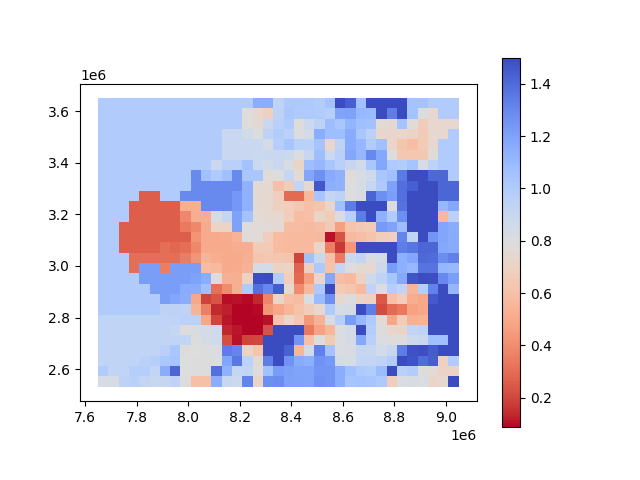

In [8]:

import geopandas as gpd
temp = gpd.GeoDataFrame(dfagg, geometry=gpd.points_from_xy(dfagg.x, dfagg.y))
temp['geometry'] = temp.buffer(20000, cap_style = 3)
p = temp.plot(column="shops_ratio", cmap='coolwarm_r', legend=True, vmax=1.5)

%matplot plt

In [19]:
dfagg['shops_ratio']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0      1.515540
1           NaN
2      0.593802
3      0.371134
4      0.929875
         ...   
995         NaN
996         NaN
997    0.000000
998         NaN
999         NaN
Name: shops_ratio, Length: 1000, dtype: float64

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

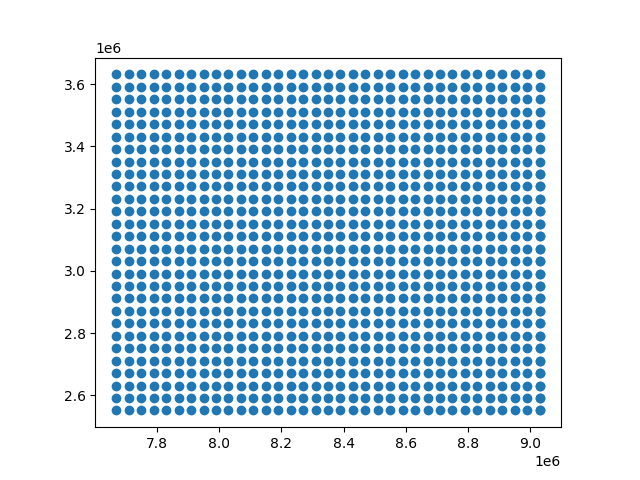

In [15]:
gidname = "GID_3"
df.loc[df['post'].isna(), 'post'] = 1
df_post = df[df['post'] == 1] 
df_post.loc[df_post.shop.isna(), 'shop'] = 1
df_post_temp = df_post.groupby([gidname]).agg(shops=("shop", "sum")).reset_index()
df_post_temp = df_post_temp.merge(gadm[[gidname, 'geometry']], on=gidname, how='left')
df_post_temp = gpd.GeoDataFrame(df_post_temp, geometry=df_post_temp.geometry, crs=crs)
df_post = df_post.groupby(['x', 'y']).agg(shops_grid=("shop", "sum")).reset_index()
df_post = gpd.GeoDataFrame(df_post, geometry=gpd.points_from_xy(df_post.x, df_post.y), crs="EPSG:3857")
df_post.plot()
%matplot plt

In [30]:
import os
states_gdf = gpd.read_file(os.path.join('s3://ipsos-dvd/fdd/data/in', 'india', 'india_states_shapefile'))

# Convert the CRS of the states GeoDataFrame to match the CRS of the Rajasthan GeoDataFrame
states_gdf = states_gdf.to_crs('epsg:3857')


# Extract the geometry for Rajasthan
rajasthan_geometry = states_gdf[states_gdf['name_1'] == 'Rajasthan']['geometry']


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

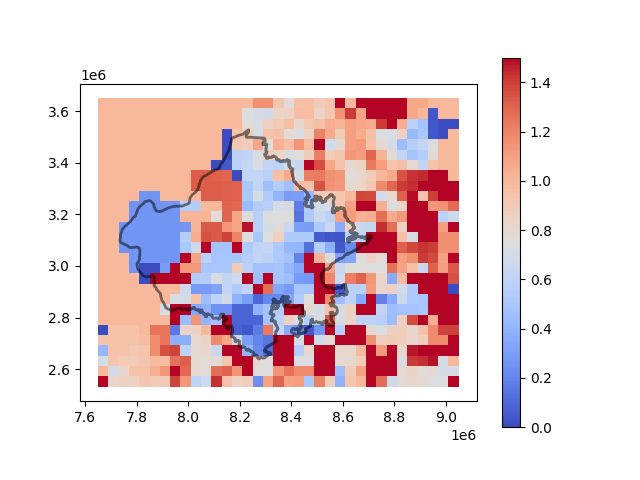

In [106]:

# Reset the limits for the zoom (to show the entire Rajasthan)
rajasthan_extent = states_gdf[states_gdf['name_1'] == 'Rajasthan'].total_bounds
xlim = (rajasthan_extent[0], rajasthan_extent[2])
ylim = (rajasthan_extent[1], rajasthan_extent[3])

# Create the plot
fig, ax = plt.subplots(1, 1)

# Plot the data
vmax = 1.5
p = temp.plot(column="shops_ratio", cmap='coolwarm',  ax=ax, legend=True, vmax=vmax)

# Plot the Rajasthan border
rajasthan_geometry.boundary.plot(color='k', linewidth=2, ax=ax, alpha=0.5)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

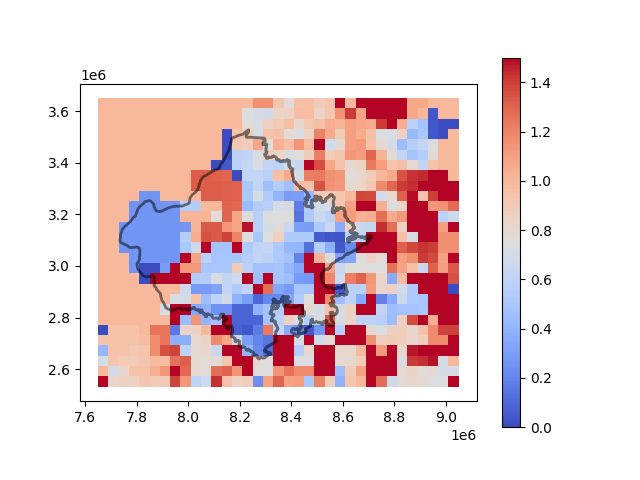

In [99]:

# Reset the limits for the zoom (to show the entire Rajasthan)
rajasthan_extent = states_gdf[states_gdf['name_1'] == 'Rajasthan'].total_bounds
xlim = (rajasthan_extent[0], rajasthan_extent[2])
ylim = (rajasthan_extent[1], rajasthan_extent[3])

# Create the plot
fig, ax = plt.subplots(1, 1)

# Plot the data
vmax = 1.5
p = temp.plot(column="shops_ratio", cmap='coolwarm',  ax=ax, legend=True, vmax=vmax)

# Plot the Rajasthan border
rajasthan_geometry.boundary.plot(color='k', linewidth=2, ax=ax, alpha=0.5)
%matplot plt